# Učitavanje biblioteka za rad 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Učitavanje podataka 

In [2]:
data = pd.read_csv('data.csv').to_numpy()
X, y = data[:,0:5], data[:,5]

print('-------------------Ucitani su podaci-------------------')
print(f'Ukupan broj ucitanih primera je: {X.shape[0]}')
print(f'Ukupan broj ucitanih prediktora (dim(X)) je: {X.shape[1]}')

-------------------Ucitani su podaci-------------------
Ukupan broj ucitanih primera je: 341
Ukupan broj ucitanih prediktora (dim(X)) je: 5


# Teorijski osvrt

Dakle, potrebno je implementirati **Ridge regresiju**, koristeci se **polinomijalnom regresijom** čiji je red polinoma unapred odredjen zadatkom i iznosi 2. 

Polinomijalna regresija drugog reda ima sledeći oblik:
$$\hat{y} = \theta_0 + \theta_1x + \theta_2x^2,$$

U ovakvim slucajevima se javlja problem da mali red modela ograničava ekspresivnost modela, odnosno model ne uspeva da dovoljno dobro isprati dinamiku koju unose ulazni podaci.
Taj problem se rešava na dva načina:
- ili povecavanjem reda modela (što u većini slučajeva nije dobro, jer dovodi do preobučavanja)
- ili regularizacijom (odlicna metoda)

Upravo jedan tip regularizacije, tzv. *L2* odnosno *Rigde* regularizaciju potrebno je implementirati ovde i inkorporirati u polinomijalnu regresiju drugog reda.

Regularizacija se uvodi u kriterijumsku funkciju kao sabirak:
$$J(\theta) = L(\hat{y}, y) + \lambda R(\theta),$$
gde je $L(\hat{y}, y)$ funkcija gubitka modela ((srednje) kvadratna greška), $\lambda$ hiper-parametar regularizacija koji odredjuje koliko ce regulazacioni sabirak ($R(\theta)$) biti penalizovan.

Regularizaciona funkcija za Rigde regularizaciju ima sledeći oblik:
$$R_{ridge}(\theta) = \sum_{i=1}^{n}{\theta_i^2},$$ gde je $n$ ukupan broj prediktora, odnosno komponenti vektora $\theta$, modela.

Hiper-parametar regularizacije $\lambda$ odredjujemo unakrsnom validacijom, minimizacijom (srednje) kvadratne greške.

In [3]:
# red polinoma 
p=2

# broj primera
m = X.shape[0] 

## Odredjivanje broja parametara vektora $\theta$

U pitanju je **Polinomijalna regresija**, pri čemu je red polimoma postavljen na $p=2$ i ona ima sledeći oblik:
$$h_{\theta}(x) = \hat{y} = \theta_0 + \theta_1x + \theta_2x^2,$$

Ovakav oblik je validan kada je broj prediktora jedan 1. Medjutim, u slučajevima kada je broj prediktora različit od nule, postoje i unakrasna množenja pojedinačnih prediktora, po principu svaki sa svakim ($x_1x_2, x_1x_3, x_1x_4, x_1x_5, x_2x_3, ...$) i, naravno, postoje čisto kvadratni "novi" prediktori ($x_1^2, x_2^2, x_3^2, x_4^2, x_5^2$). 

Ukupan broj parametara u vektoru $\theta$ odredjen je:
- $\theta_0$ srednja vrednost (ovu vrednost odredjujemo kao srednju vrednost izlaznih primera $y_i$)
- 5 "linearnih" prediktora 
- 5 "kvadratnih" prediktora 
- kombinacija bez ponavljanja 5 "linearnih" prediktora - 10 parametara.

Dakle, ukupno 20 parametara, koji se nalaze u vektoru $\theta$ - za svaki prediktor, i jedan nulti parametar $\theta_0$.

In [4]:
# broj prediktora 
n=20

print(f'Red polinoma: p = {p}\nBroj prediktora: n = {n}\nBroj primera: m = {m}\n')

Red polinoma: p = 2
Broj prediktora: n = 20
Broj primera: m = 341



# Implementacija potrebnih funkcija

In [5]:
def read_data(path: str='data.csv', separator_index: int=5) -> tuple:
    
    """
        Funkcija za ucitavanje podataka na osnovu kojih se
        kreira model.
        
        :params: 
            - path: putanja do .csv fajla sa podacima
            - separator_index: broj kolone do koje se nalaze
                               ulazni podaci, odnosno od koje
                               pocinju izlazni podaci
                               
        :return:
            - X: matrica primera svih prediktora
            - y: vektor izlaza
    """
    
    data = pd.read_csv(path).to_numpy()
    
    # razdvajanje ulaznih i izlaznih promenljivih
    X, y = data[:,0:separator_index], data[:,separator_index]
    
    return X, y

In [6]:
def make_polynomial_features(X: np.ndarray) -> np.ndarray:
    
    """
        Funkcija za kreiranje polinomijalnih obelezja (drugog reda) od 
        obelezja datih kroz n-dimenzionu matricu X. 
        
        Broj kolona matrice X predstavlja broj prediktora, a broj njenih 
        vrsta prestavlja broj primera. 
        
        :params: 
            - X: matrica linearnih prediktora
            
        :return:
            - X: matrica primera svih polinomijalnih prediktora 
    """
    
    # broj primera
    m = X.shape[0] 
    
    # stari broj prediktora - kao za linearnu regresiju
    n_old_features = X.shape[1] 
    
    # kreiranje polinomijalnih obelezja svih stepena
    for i in range(n_old_features):
        for j in range(i, n_old_features):
            product = np.asarray(X[:,i]*X[:,j]).reshape((m,1))
            X = np.concatenate((X, product), axis=1)
    
    return X

In [7]:
def train_test_data_split(X: np.ndarray, y: np.ndarray, split_ratio: float=0.8) -> tuple:
    
    """
        Funkcija za splitovanje svih dostupnih podataka na trening/obucavajuce
        i test podatke prema zadatom postotku (split_ratio).
        
        :params:
            - X: matrica primera svih prediktora
            - y: vektor izlaza
            - split_ratio: vrednost iz intervala [0,1] koja oznacava procenat
                           trening podataka
                           
        :return:
            - X_train: matrica primera svih prediktora za trening skup
            - y_train: vektor izlaza za trening skup
            - X_test: matrica primera svih prediktora za test skup
            - y_test: vektro izlaza za test skup
    """
    
    random.seed(1)
    
    m = X.shape[0]
    
    train_set_size = int(m*split_ratio)
    
    ind = np.arange(0,m).tolist()
    
    # odredjivanje indeksa za trening skup
    train_set_ind = random.sample(ind, k=train_set_size)
    
    # odredjivanje indeksa za test skup
    test_set_ind = list(set(ind) - set(train_set_ind))
    
    # podela podataka na trening i test podatke
    X_train, y_train = X[train_set_ind], y[train_set_ind]
    X_test, y_test = X[test_set_ind], y[test_set_ind]
    
    return X_train, y_train, X_test, y_test

In [8]:
def get_fold_indeces(m: int, k: int=5) -> list:
    
    """
        Funkcija za dohvatanje listi pocetnih i krajnjih indeksa
        foldova na osnovu prosledjenog broja foldova - k i velicine celokupnog seta
        podataka - m.
        
        :params:
            - m: velicina skupa (broj primera jednog skupa) koji treba podeliti
                 u foldove
            - k: broj foldova
            
        :return:
            - fold_indeces: lista koja sadrzi liste u kojima su pocetna i krajnja tacka
                            svakog folda ponaosob
    """
    
    fold_size = int(m/k)
    
    fold_indeces = []
    
    for i in range(k):
        fold_indeces.append([i*fold_size, (i+1)*fold_size if i != k-1 else m])
        
    return fold_indeces  

In [9]:
def get_fold(X: np.ndarray, y: np.ndarray, fold_index: list) -> tuple:
    
    """
        Funkcija za dohvatanje jednog folda podataka na osnovu proslednje
        liste koja sadrzi pocetni i krajnji indeks jednog folda.
        
        :params:
            - X: matrica primera svih prediktora iz koje treba izvuci jedan fold
            - y: vektor izlaza iz kojeg treba izvuci jedan fold
            - fold_index: lista koja sadrzi pocetni i krajnji indeks folda
                          koji treba izvuci
        
        :return:
            - (X_fold, y_fold): tuple sa izvucenim foldovima
    """
    
    X_fold = X[fold_index[0]:fold_index[1],:]
    
    y_fold = y[fold_index[0]:fold_index[1]]
    
    return (X_fold, y_fold)

In [10]:
def concat_folds(fold_1: tuple, fold_2: tuple=None) -> tuple:
    
    """
        Funkcija za spajanje dva odvojena folda podataka 
        koji u sebi sadrze i ulazne i izlazne podatke.
        
        :params:
            - fold_1: tuple koji sadzi X matricu i y vektor, respektivno,
                      koje treba spojiti sa fold_2
            - fold_2: tuple koji sadzi X matricu i y vektor, respektivno,
                      koje treba spojiti sa fold_1 
                      
                      **NOTE** fold_2 moze biti i None, u tom slucaju, funkcija vraca samo fold_1\
                      
        :return:
            - (X_concat, X_concat): tuple sa spojenim foldovima
    """
    
    try:
        X_1, y_1 = fold_1[0], fold_1[1]
        X_2, y_2 = fold_2[0], fold_2[1]

        # spajanje foldova ukoliko fold_2 postoji
        X_concat = np.concatenate((X_1, X_2), axis=0)
        Y_concat = np.concatenate((y_1, y_2), axis=0)
        
        return (X_concat, Y_concat)
    except:
        
        # vracanje samo prvog folda - fold_1, ukoliko fold_2 ne postoji
        return fold_1

In [11]:
def get_validation_and_train_folds(X: np.ndarray, y: np.ndarray, validation_fold_index: int, fold_indeces: list) -> tuple:
    
    """
        Funkcija za dohvatanje jednog folda podataka za validaciju i ostatak podataka
        za obucavanje.
        
        :params:
            - X: matrica primera svih prediktora
            - y: vektor izlaza
            - validation_fold_index: indeks iz elemeta liste fold_indeces za koji treba
                                     izvuci validacioni skup
            - fold_indeces: lista sa indeksima foldova
            
        :return:
            - validation_fold: fold podataka koji predstavlja validacioni skup
            - train_folds: spojeni svi preostali foldovi koji predstavljaju trening skup
    """
    
    # dohvatanja validacionog folda podataka
    validation_fold = get_fold(X, y, fold_indeces[validation_fold_index])
    
    # inicijalizacija trening foldova
    train_folds = None
    
    # dohvatanje trening foldova
    for i in range(len(fold_indeces)):
        if i != validation_fold_index:
            # dohvatanje pojedinacnog trening folda
            train_fold = get_fold(X, y, fold_indeces[i])
            # spajanje dohvacenog trening folda sa ostalim trening foldovima
            train_folds = concat_folds(train_fold, train_folds)
    
    return validation_fold, train_folds

In [12]:
def get_statistics(X: np.ndarray) -> tuple:
    
    """
        Funkcija za dohvatanje statistika - srednja vrednost i standardna devijacija. 
        Za svaka od kolona matrice X vrsi se izracunavanje statistika, s obzirom na to da
        one predstavljaju posebne prediktore.
        
        :params:
            - X: matrica primera svih prediktora
            
        :return:
            - mu: vektor srednjih vrednosti za svaki prediktor
            - std: vektor standardnih devijacija za svaki prediktor
    """
    
    # broj prediktora
    n = X.shape[1]
    
    # vektor srednjih vrednosti za svaki prediktor ponaosob
    mu = np.zeros(n)
    
    # vektor standardnih devijacija za svaki prediktor ponaosob
    std = np.zeros(n)
    
    for i in range(n):
        mu[i] = np.mean(X[:,i])
        std[i] = np.std(X[:,i])
    
    return mu, std

In [13]:
def standardize(X: np.ndarray, mu: np.ndarray=None, std: np.ndarray=None) -> np.ndarray:
    
    """
        Funkcija za standardizaciju prediktora - postavljanje prediktora na istu skalu.
        Svaka kolona matrice X se standardizuje sa sebi svojstvenim statistikama - mu i std,
        s obzirom na to da su to posebni prediktori i da u opstem slucaju ne moraju biti na istoj skali.
        
        :params:
            - X: matrica primera svih prediktora
            - mu: vektor srednjih vrednosti za svaki prediktor ili None
            - std: vektor standardnih devijacija za svaki prediktor ili None
            
        :return:
            - X: standardizovana matrica primera svih prediktora
    """
    
    # racunanje srednjih vrednosti i st. devijacije svih prediktora
    if mu is None and std is None:
        mu, std = np.mean(X, axis=0), np.std(X, axis=0)

    # standardizacija na normalnu raspodelu
    X = (X - mu) / std # ~ N(0,1)
    
    return X

In [14]:
def center_outputs(y: np.ndarray) -> float:
    
    """
        Funkcija za centriranje izlaznih podataka oko
        sopstevene srednje vrednosti.
        
        :params:
            - y: vektor izlaza
        
        :return:
            - y_center: vektor centriranih izlaza (oduzeta srednja vrednost) 
    """
    
    # racunanje sr. vrednosti vektora izlaza
    y_mean = np.mean(y)
    
    # centriranje 
    y_center = y-y_mean
    
    return y_center

In [15]:
def calculate_theta_ridge(X: np.ndarray, y_center: np.ndarray, lambda_param: float) -> np.ndarray:
    
    """
        Funkcija za analiticko racunanje optimalnih parametara Theta koristeci se 
        Ridge regresijom. 
        
        :params:
            - X: matrica primera svih prediktora
            - y_center: vektor centriranih izlaza
            - lambda_param: hiper-parametar regularizacija
            
        :return:
            - theta: vektor parametara (bez theta0) izracunatih prema formuli za Ridge 
                     regresiju
    """
    
    # broj prediktora = broj parametara
    n = X.shape[1]
    theta = np.zeros((n,), dtype='float32')
    
    # racunanje parametara theta prema formuli 
    theta = np.linalg.inv(X.transpose()@X + lambda_param*np.identity(n))@X.transpose()@y_center
    
    return theta

In [16]:
def l2_norm(vec_1: np.ndarray, vec_2: np.ndarray=None) -> float:
    
    """
        Funkcija za racunanje L2 norme vektora.
        Racuna se suma kvadrata svih elemenata vektora.
        
        :params:
            - vec_1: prvi vektor
            - vec_2: drugi vektor ili None
            
        :return:
            - l2_norm: L2 norma vektora (ili razlike vektora, ako postoji vec_2),
                       tj. suma kvadrata svih elemenata vektora
    """
    
    try:
        l2_norm = sum((vec_1-vec_2)**2)
    except:
        l2_norm = sum(vec_1**2)
    
    return l2_norm

In [17]:
def predict(X: np.ndarray, theta: np.ndarray, theta0: float) -> np.ndarray:
    
    """
        Funkcija koja vrsi predikciju, odnosno daje estimirane
        izlazne vrednosti na osnovu trenutno formiranog modela.
        
        :params:
            - X: matrica primera svih prediktora
            - theta: vektor parametara za svaki prediktor
            - theta0: theta0 parametar
            
        :return:
            - y_hat: vektor prediktovanih izlaza
    """
    
    # racunanje predikcije izlaza - hipoteza
    y_hat = theta0 + (theta.reshape(1,-1)@X.transpose()).flatten() 
    
    return y_hat

In [18]:
def mse(y_hat: np.ndarray, y_true: np.ndarray, root: bool=False) -> float:
    
    """
        Funkcija za racunananje (korena) srednje kvadratne greske
        predikcije modela. Dakle, ujedno funkcija za MSE i RMSE.
        
        :params:
            - y_hat: prediktovani izlaz modela
            - y_true: pravi/istiniti izlaz modela
            - root: indikator za RMSE
            
        :return:
            - value: izracunata vrednost (R)MSE-a za date vektore
    """
    
    if root: 
        # racunanje RMSE-a
        value = (l2_norm(y_hat, y_true) / y_true.size)**0.5
    else:
        # racunanje MSE-a
        value = l2_norm(y_hat, y_true) / y_true.size
    
    return value

In [19]:
def loss(y_hat: np.ndarray, y_true: np.ndarray, theta: np.ndarray, lambda_param: float=0.0) -> float:
    
    """
        Funkcija za racunanje vrednosti funkcije gubitka - loss funkcije.
        Tehnicki, ono se sada, tj. sa regularizacijom zove kriterijumska funkcija, ali zbog
        lakseg asociranja, uzeto je ime funkcija gubitka.
        
        :params:
            - y_hat: prediktovani izlaz modela
            - y_true: pravi/istiniti izlaz modela
            - theta: vektor parametera modela
            - lambda_param: hiper-parametar regularizacije
            
        :return:
            - loss_value: vrednost funkcije gubitka
    """
    
    # racunanje srednje kvadratne greske
    mean_sq_error = mse(y_hat, y_true) 
    
    # racunananje regularizacije
    regularization_part = lambda_param*l2_norm(theta)
    
    # ukupna vrednost funkcije gubitka
    loss_value = mean_sq_error + regularization_part
    
    return loss_value

In [20]:
def cv_ridge(X_train: np.ndarray, y_train: np.ndarray, theta0: float, lambda_param: float = 0.0, k: int=10, rmse: bool=False) -> tuple:
    
    """
        Funkcija za unakrsnu validaciju kod Ridge regresije.
        U funkciji se vrsi sledece:
            - splitovanje podataka na k foldova
            - od k foldova, 1 je validacioni fold, a svi ostali su trenirajuci podaci
            - racunanje srednje vrednosti i std. devijacije obucavajuceg skupa podataka
            - standardizacija obucavajuceg i validacionog skupa sa prethodno izracunatim statistikama
            - nakon toga se vrsi odredjivanje parametara regresije
            - theta0 se odredjuje kao srednja vrednost necentriranih izlaznih vrednosti 
            - theta vektor se odredjuje analitickom folmulom
            - potom se vrsi predikcija tako dobijenog modela za obucavajuci i validacioni skup podataka
            - za obucavajuci i validacioni skup podataka se racuna funkcija gubitka modela - loss
            - racunaju se srednje vrednosti i std. devijacije loss-ova za sve foldove i one se vracaju za obucavajuci i validacioni skup podataka
            
        :params:
            - X_train: trenirajuci skup ulaznih podataka, matrica primera svih prediktora
            - y_train: trenirajuci skup izlaznih podataka, vektor izlaza
            - theta0: parametar theta0, srednja vrednost vektora izlaza na trenirajucem skupu 
            - lambda_param: hiper-parametar regularizacije
            - k: broj foldova za unakrsnu validaciju
            - rmse: indikator za racunanje RMSE-a
            
        :return:
            - train_mean: srednja vrednost metrike (MSE/RMSE) na trening skupovima 
                          prilikom vrsenja unakrsne validacije
            - train_std: standardna devijacija metrike (MSE/RMSE) na trening skupovima
                         prilikom vrsenja unakrsne validacije
            - val_mean: srednja vrednost metrike (MSE/RMSE) na validacionim skupovima 
                        prilikom vrsenja unakrsne validacije
            - val_std: standardna devijacija metrike (MSE/RMSE) na validacionim skupovima
                       prilikom vrsenja unakrsne validacije
    """
    
    # dohvatanje pocetnih i krajnjih indeksa svih foldova
    fold_indeces = get_fold_indeces(m=X_train.shape[0], k=k)
    
    # inicijalizacija listi za cuvanje vrednosti metrika
    metrics_train, metrics_val = [], []

    # petlja po iteracijama unakrsne validacije
    for i in range(k):
        # dohvatanje validacionog i trening skupa
        val, train = get_validation_and_train_folds(X_train, y_train, i, fold_indeces)

        # otpakivanje skupova na ulazne i izlazne 
        train_x, train_y = train[0], train[1]
        val_x, val_y = val[0], val[1]

        # dohvatanje sr. vrednosti i st. devijacije trening skupa
        mu, std = get_statistics(train_x)

        # standardizacija trening skupa 
        train_x = standardize(train_x)
        
        # standardizacija validacionog skupa sa statistikama iz trening skupa
        val_x = standardize(val_x, mu, std)

        # racunanje parametara modela
        theta = calculate_theta_ridge(train_x, center_outputs(train_y), lambda_param)
        
        # predikcija izlaza za trening skup
        train_y_hat = predict(train_x, theta, theta0)
        
        # racunanje metrike za trening skup
        metrics_train.append(mse(train_y_hat, train_y, rmse))
            
        # predikcija izlaza za validacioni skup
        val_y_hat = predict(val_x, theta, theta0)
        
        # racunanje metrike za trening skup
        metrics_val.append(mse(val_y_hat, val_y, rmse))
        
    # konverzija listi u np.array
    metrics_train = np.array(metrics_train)
    metrics_val = np.array(metrics_val)

    # racunanje srednjih vrednosti i st. devijacije metrika
    train_mean = np.mean(metrics_train)
    train_std = np.std(metrics_train)
    
    val_mean = np.mean(metrics_val)
    val_std = np.std(metrics_val)
    
    return train_mean, train_std, val_mean, val_std

In [21]:
def optimal_lambda_search(X_train: np.ndarray, y_train: np.ndarray, lambdas: np.ndarray, k: int=10, rmse: bool=False, verbose: bool=False) -> float:
    
    """
        Funkcija za pretrazivanje optimalnog hiper-parametra Rigde regresije.
        Funkcija vrsi unakrsnu validaciju za svako lambda iz prosledjenog niza lambdas 
        i odredjuje optimalnu vrednost lambda parametra kao onu koja je dala minimalnu
        vrednost srednje kvadratne greske na validacionom skupu.
        
        :params:
            - X_train: trenirajuci skup ulaznih podataka, matrica primera svih prediktora
            - y_train: trenirajuci skup izlaznih podataka, vektor izlaza
            - lambdas: vektor svih mogucih hiper-parametara regularizacije, od kojih se trazi optimalan
            - k: broj foldova unakrsne validacije
            - rmse: indikator za racunanje RMSE-a umesto MSE-a
            - verbose: indikator za ispis progresa pretrage
            
        :return:
            - lambda_opt: optimalna vrednost hiper-parametra regularizacije
    """
    
    # racunanje srednje vrednosti izlaza - theta0
    theta0 = np.mean(y_train)
    
    # inicijalizacija listi za cuvanje statisika metrika za sve lambde
    mean_train_list, std_train_list = [], []
    mean_val_list, std_val_list = [], []

    # petlja po svim vrednostima lambda hiper-parametra iz proslednjog niza
    for i, lambda_param in enumerate(lambdas):
        # unakrsna validacija za i-to lambda, procena metrike za i-to lambda
        mean_train, std_train, mean_val, std_val = cv_ridge(X_train, y_train, theta0, lambda_param, k, rmse)

        # cuvanje statisika metrika za i-to lambda
        mean_train_list.append(mean_train)
        std_train_list.append(std_train)

        mean_val_list.append(mean_val)
        std_val_list.append(std_val)
        
        # ispis progresa pretrage
        if verbose:
            percentage = 100*i/lambdas.size
            print('Pretrazeno je {:.5}% prosledjenih podataka.'.format(percentage), end='\r')

    # konverzija listi u np.array
    mean_train_arr = np.array(mean_train_list)
    std_train_arr = np.array(std_train_list)

    mean_val_arr = np.array(mean_val_list)
    std_val_arr = np.array(std_val_list)
    
    # optimalno lambda je ono kod koga je najmanja (najmanja jer je u pitanju (R)MSE, a to je nenegativna velicina) metrika 
    # na validacionom skupu
    lambda_opt = lambdas[np.argmin(mean_val_arr)]
    print(f'Pronadjena je optimalna vrednost hiper-parametra Lambda: {lambda_opt}')

    # iscrtavanje grafika za trening i validacioni skup 
    # u zavisnosti od hiper-parametra lambda
    fig = plt.figure(figsize=(10,8), dpi=100)
    plt.plot(lambdas, mean_train_arr, color='darkorange', label='obucavajuci skup')
    plt.fill_between(lambdas, mean_train_arr - std_train_arr, mean_train_arr + std_train_arr, alpha=0.2, color='bisque')

    plt.plot(lambdas, mean_val_arr, color='royalblue', label='validacioni skup')
    plt.fill_between(lambdas, mean_val_arr - std_val_arr, mean_val_arr + std_val_arr, alpha=0.2, color='lightsteelblue')
    
    # iscrtavanje optimlanog lambda
    plt.axvline(x=lambda_opt, linestyle='-.', color='darkred', label='optimalno $\lambda$')
    
    name = 'RMSE' if rmse else 'MSE'
    
    plt.xlabel('$\lambda$')
    plt.ylabel(name)
    plt.title(name+' obucavajucem i validacionom skupu u zavisnosti od $\lambda$')
    plt.legend(loc='best')
    plt.show()
       
    return lambda_opt

In [22]:
def train_with_optimal_lambda(X_train: np.ndarray, y_train: np.ndarray, lambda_opt: float) -> tuple:
    
    """
        Funkcija za analiticko odredjivanje (da nije u pitanju Ridge regresija, bilo bi treniranje,
        te otuda i ime 'train') parametara theta0 i vektora theta nad celim obucavajucim skupom i to 
        sa optimalno izabranim parametrom lambda.
        
        :params:
            - X_train: trenirajuci skup ulaznih podataka, matrica primera svih prediktora
            - y_train: trenirajuci skup izlaznih podataka, vektor izlaza
            - lambda_opt: optimalna vrednost hiper-parametra regularizacije
            
        :return:
            - theta: vektor parametara modela
            - theta0: nulti parametar, tj. srednja vrednost izlazne promenljive
    """
    
    # racunanje srednje vrednosti izlaza - theta0
    theta0 = np.mean(y_train)
    
    # standardizacija ulazne matrice primera svih prediktora
    X_train = standardize(X_train)
    
    # analiticko racunanje parametara modela 
    theta = calculate_theta_ridge(X_train, center_outputs(y_train), lambda_opt)
    
    return theta, theta0

In [23]:
def save_params(theta: np.ndarray, theta0: float, path: str='params.csv') -> None:
    
    """
        Funkcija za dump-ovanje/cuvanje parametara modela u .csv fajl.
        
        :params:
            - theta: vektor sa parametrima modela
            - theta0: nulti parametar modela
            - path: putanja ka .csv fajlu
            
        :return:
            None
    """
    
    # inicijalizacija niza za sve parametre
    params = np.zeros((theta.size + 1,))
    
    # nadovezivanje parametara
    params[0] = theta0
    params[1:] = theta
    
    # cuvanje parametara
    pd.DataFrame(params).to_csv(path, index=False)

In [24]:
def load_params(path: str='params.csv') -> tuple:
    
    """
        Funkcija za ucitavanje parametara modela iz .csv fajla.
        
        :params:
            - path: putanja do .csv fajla
            
        :return:
            - theta: vektor sa parametrima modela
            - theta0: nulti parametar modela
    """
    
    # citanje iz .csv fajla
    params = np.squeeze(pd.read_csv(path).to_numpy())
    
    # dohvatanje nultog parametra
    theta0 = params[0]
    
    # dohvatanje vektora parametara modela
    theta = params[1:]
    
    return theta, theta0

In [25]:
def estimate_new_data(X: np.ndarray, theta: np.ndarray, theta0: float) -> np.ndarray:
    
    """
       Funkcija za procenjivanje izlaza na osnovu zadate matrice prediktora X - ulaza.
       Funkcija sluzi za test podatke.
       Funkcija formira novu matricu polinomijalnih prediktora (radi samo za red polinoma 2),
       potom standardizuje sve dobijene prediktore i na kraju vrsi predikciju izlaza
       na osnovu prosledjenih paramatera modela - theta.
       
       :params:
           - X: matrica primera svih linearnih prediktora
           - theta: vektor parametara modela
           - theta0: nulti parametar modela
           
       :return:
           - y_hat: predikcija modela
    """
    
    # kreiranje polinomijanih prediktora 
    X_poly = make_polynomial_features(X)
    
    # standardizacija prediktora
    X_poly = standardize(X_poly)
    
    # predikcija modela
    y_hat = predict(X_poly, theta, theta0)
    
    return y_hat

# Traženje optimalnog hiper-parametra $\lambda$

Ovaj model, generalno ima 2 hiper parametra:
- red polinoma - p
- jačina regularizacije - $\lambda$.

Red polinoma je u zadatku fiksiran, tako da je potrebno samo pronaći optimlano $\lambda$.\
Optimalan parametar $\lambda$ odredjuje se unakrsnom validacijom, pri čemu vršimo pretragu po svim lambdama iz nekog opsega.

Unaksne validacija (*eng. cross validation*) jeste jedna od najboljih metoda za procenu performansi modela.\
To je postupak u kojem celi skup podataka (uglavnom skup podataka koji su rezervisani za obučavanje) podelimo na *k* delova, tzv. foldovi, jedan fold podataka proglasimo 
da je validacioni skup, a preostalih *k-1* proglasimo da pripadaju obučavajućem skupu. Zatim "istreniramo" naš model na novonastalom obučavajućem skupu (i uzmemo vrednosti metrika) i 
izracunamo vrednost adekvatne metrike tako dobijenog modela za predikcije iz validacionog skupa. To sve ponavljamo *k* puta, uzimajući uvek različiti set podataka za validacioni skup.\
Na kraju samo usrednjimo dobijene metrike i dobijamo procenu metrike (npr. srednje kvadratna greška izlaza), odnosno procenu tačnosti našeg modela na validacionom skupu. 

Ovakav postupan možemo da ponavljamo za svako $\lambda$ iz nekog opsega vrednosti. Ono $\lambda$ koje na validacionom skupu daje minimalnu (minimalnu ukoliko je metrika nenegativna kao npr. (R)MSE) grešku, proglašavamo našim optimalnim parametrom $\lambda$. 

Taj postupak vrši se priloženim kodom ispod. 

Potrebno je još spomenuti, da je, radi procene stvarne greške modela u produkciji, celokupan skup podataka potrebno je podeliti na dva podskupa:
- obučavajući - uglavnom čini od 70 do 90% ukupnih podataka
- testirajući - uglavnom čini od 10 do 30% ukupnih podataka

Na obučavajućem ili trening skupu sve vrši treniranje modela, unakrsna validacija i pronalaženje optimalnog $\lambda$, a na testirajućem skupu se vrši merenje performansi modela kroz adekvatnu metriku.

Pronadjena je optimalna vrednost hiper-parametra Lambda: 24.196482412060305


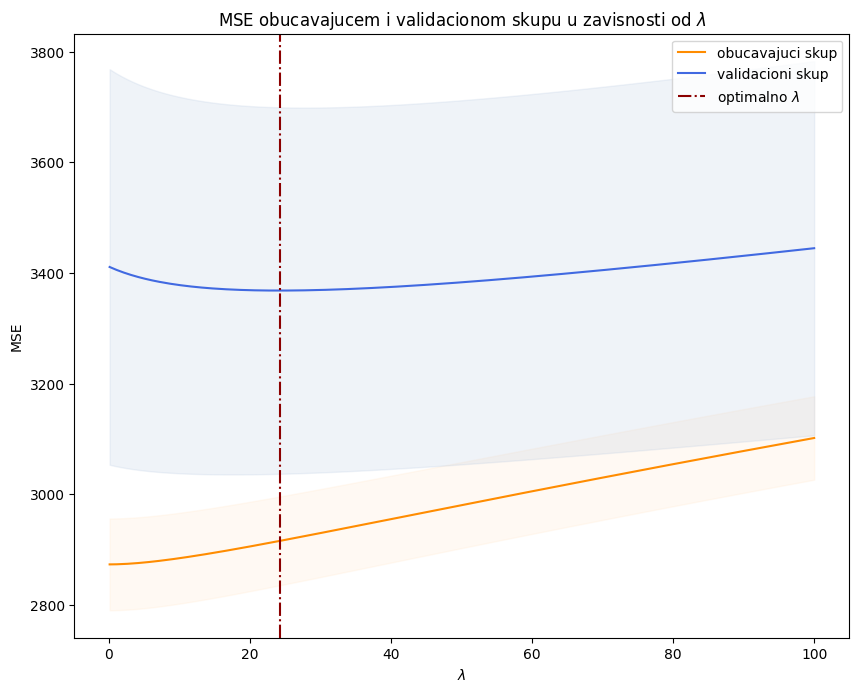

In [26]:
# ucitavanje podataka
X, y = read_data()

# podela podataka na trening i test skup
X_train, y_train, X_test, y_test = train_test_data_split(X, y, split_ratio=0.8)

# kreiranje polinomijalnih prediktora za trening skup
X_train = make_polynomial_features(X_train)

# formiranje niza svih mogucih vrednosti za hiper-parametar lambda
lambdas = np.linspace(0.1, 100, 200)

# pretraga unakrsnom validacijom za optimalno lambda
lambda_opt = optimal_lambda_search(X_train, y_train, lambdas, k=5, rmse=False, verbose=True)

Dakle, pronadjena optimalna vrednost hiper-parametra $\lambda$ iznosi otprilike 24. Ova vrednost na prestavlja ni preveliku, ni premalu vrednost za ovaj hiper-parametar, u smislu da daje adekvatna regularizaciju modela. Premalo $\lambda$, npr. 1e-5 značilo bi da regularizacije modela uopšte nema, dok bi veliko $\lambda$, npr. 1000 značilo da se model previše regularizuje i da se preveliki znacaj pridaje parametrima modela, a ne i performansama modela.\
Zbog toga optimalna vrednost $\lambda$ hiper-parametra dovoljno dobro vrši regularizaciju, penalizujući parametre modela, ali i predikcije takvog modela su dovoljno dobre, što je suština ove pretrage. 

Potrebno je samo argumentovati da je na prikazanom grafiku sa razlogom prikazana zavisnost MSE-a od hiper-parametra $\lambda$, a ne funkcija gubitka modela, jer se na taj način odredjivanjem $\lambda$ kao argumenta koji daje minimalno MSE na validacionom skupu, nešto veći značaj pridaje tačnoj predikciji nego parametrima modela.

# Učenje parametara modela sa optimalnim parametrom $\lambda$

In [27]:
# racunanje finalnih parametara modela
theta, theta0 = train_with_optimal_lambda(X_train, y_train, lambda_opt)

# cuvanje finalnih parametara modela
save_params(theta, theta0)

# Evaluacija modela na test skupu

In [28]:
# ucitavanje parametara modela
theta, theta0 = load_params()

# predikcija izlaza za test skup
y_test_hat = estimate_new_data(X_test, theta, theta0)

# procena RMSE za test skup
test_rmse = mse(y_test_hat, y_test, root=True)

# procena RMSE za trening i validacioni skup
train_rmse, _, val_rmse, _ = cv_ridge(X_train, y_train, theta0, lambda_opt, k=10, rmse=True)

# ispis procenjenih RMSE-ovan
rmse_dict = {'trenirajuci skup': [train_rmse],
             'validacioni skup': [val_rmse],
             'testirajuci skup': [test_rmse]}

rmse_df = pd.DataFrame(rmse_dict, index=['RMSE'])
rmse_df

,trenirajuci skup,validacioni skup,testirajuci skup
RMSE,54.140383,57.334421,55.498883


Prikazane su vrednosti korena srednje kvadratne greške na svim skupovima.\
Očekivano, RMSE na trenirajućem skupu je ima najmanju vrednost. 

Pored toga, s obzirom na to da su vrednosti svih RMSE-ova u prilično sličnom opsegu, moguća je generalizacija modela.

# Testiranje valjanosti implementacije pomocu scikit-learn biblioteke

In [29]:
# ucitavanje potrebnih klasa
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import RidgeCV

# ucitavanje podataka
X, y = read_data()
X_train, y_train, X_test, y_test = train_test_data_split(X, y, split_ratio=0.8)

# kreiranje polinomijalnih prediktora drugog reda
X_2 = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_train)

# standardizacija prediktora
scaler = StandardScaler().fit(X_2)
X_2 = scaler.transform(X_2)

# pretraga optimalnog hiper-parametra lambda (u sklearn-u, alpha) unakrsnom validacijom
ridge_reg = RidgeCV(cv=5, alphas=np.linspace(0.1, 100, 200)).fit(X_2, np.squeeze(y_train))
print(f'Pronadjen optimalan hiper-paremetar lambda za "sklearn" model iznosi: {ridge_reg.alpha_}')

# evaluacija modela na test skupu

# kreiranje polinomijalnih odlika
X_test_2 = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_test)

# standardizacija prediktora
X_test_2 = scaler.transform(X_test_2)

# prekcija izlaza
y_pred_ridge = ridge_reg.predict(X_test_2)

# racuananje metrike
test_rmse = mse(y_pred_ridge, y_test, root=True)
print(f'RMSE na test skupu za "sklearn" model iznosi: {test_rmse}')

Pronadjen optimalan hiper-paremetar lambda za "sklearn" model iznosi: 29.216582914572868
RMSE na test skupu za "sklearn" model iznosi: 56.53634873715565


Vrednost optimalnog parametra $\lambda$ je nešto veća od one dobijene implementacijom, ali ove vrednost poprilično "liči" na onu dobijenu ovom implementacijom.
Takodje, RMSE na test skupu ima vrednost vrlo sličnu onoj dobijnom testiranjem implementiranog modela.

Dakle, može se zaključiti da je implementiran model valjan.

# Uporedjivanje dobijenih parametara

In [30]:
# ucitavanje parametara
theta, theta0 = load_params()

# formiranje recnika za pd.DataFrame
skl_theta_dict = {'$\theta_0$': [theta0, ridge_reg.intercept_]}

for i in range(len(ridge_reg.coef_)):
    string = '$\theta_{' + str(i+1) + '}$'
    skl_theta_dict[string] = [theta[i], ridge_reg.coef_[i]]
    
skl_theta_df = pd.DataFrame(skl_theta_dict, index=['Implementacija', 'Scikit-learn']).transpose()
skl_theta_df

,Implementacija,Scikit-learn
$\theta_0$,154.205882,154.205882
$\theta_{1}$,26.777838,26.270035
$\theta_{2}$,-7.234151,-6.790829
$\theta_{3}$,7.627271,7.664585
$\theta_{4}$,24.395588,23.829983
$\theta_{5}$,5.887377,6.057345
$\theta_{6}$,3.516963,3.780532
$\theta_{7}$,-5.275067,-5.083604
$\theta_{8}$,1.095337,0.932698
$\theta_{9}$,3.550339,3.265818


U prilog valjanosti modela ide i činjenica da su parametri, priloženi u tabeli iznad, vrlo sličnih vrednosti.\

Primetno je, da parametri $\theta_1$ i $\theta_4$ imaju znatno veće vrednosti od ostalih parametara, što bi značilo da učitan set podataka verovatno većinski potiče od raspodele prediktora $X_1$ i $X_4$ i potencijalno nekih korelisanih odbiraka prediktora $X_2$ i $X_4$, s obzirom na to da parametar $\theta_{13}$ koji odgovara prediktoru $X_2X_4$ ima vrednost preko 11.

